In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_curve,auc

In [2]:
sns.set(style='whitegrid')

In [9]:
# 1️⃣ Load Data
train_df=pd.read_csv('train.csv')
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [11]:
test_df=pd.read_csv('test.csv')
test_df
submission_ids=test_df['PassengerId']
submission_ids

,PassengerId
0,892
1,893
2,894
3,895
4,896
...,...
413,1305
414,1306
415,1307
416,1308


In [8]:
# Combine data for consistent preprocessing
combined_df = pd.concat([train_df.drop('Survived', axis=1), test_df], ignore_index=True)


In [15]:
combined_df['FamilySize']=combined_df['SibSp']+combined_df['Parch']+1
combined_df['IsAlone'] = (combined_df['FamilySize'] == 1).astype(int)

In [17]:
combined_df['Title'] = combined_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)


<>:1: SyntaxWarning: invalid escape sequence '\.'
<>:1: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipython-input-1034481001.py:1: SyntaxWarning: invalid escape sequence '\.'
  combined_df['Title'] = combined_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)


In [19]:
title_map = {
    'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master',
    'Dr': 'Other', 'Rev': 'Other', 'Col': 'Other', 'Major': 'Other',
    'Mlle': 'Miss', 'Countess': 'Mrs', 'Ms': 'Miss', 'Lady': 'Mrs',
    'Don': 'Mr', 'Sir': 'Mr', 'Jonkheer': 'Other', 'Dona': 'Mrs', 'Capt': 'Other'
}
combined_df['Title']=combined_df['Title'].map(title_map)

In [23]:
combined_df['Age'].fillna(combined_df['Age'].median(), inplace=True)
combined_df['Fare'].fillna(combined_df['Fare'].median(),inplace=True)
combined_df['Embarked'].fillna(combined_df['Embarked'].mode()[0],inplace=True)

/tmp/ipython-input-2986939454.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_df['Age'].fillna(combined_df['Age'].median(), inplace=True)
/tmp/ipython-input-2986939454.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, in

In [25]:
combined_df['AgeGroup']=pd.cut(combined_df['Age'],bins=[0, 16, 32, 48, 64, 80], labels=[0, 1, 2, 3, 4])
combined_df['FareCategory']=pd.cut(combined_df['Fare'],4, labels=[0, 1, 2, 3])

In [26]:
combined_df['Deck'] = combined_df['Cabin'].apply(lambda x: str(x)[0] if pd.notnull(x) else 'M')



In [27]:
combined_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Age', 'Fare'],axis=1,inplace=True)

In [28]:
combined_df=pd.get_dummies(combined_df,columns=['Sex', 'Embarked', 'Title', 'AgeGroup', 'FareCategory', 'Deck'],drop_first=True)

In [33]:
X_train_full = combined_df.iloc[:len(train_df), :]
X_test_submission = combined_df.iloc[len(train_df):, :]
y_train_full = train_df['Survived']


In [34]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)


In [37]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
model=GridSearchCV(RandomForestClassifier(random_state=42),param_grid,cv=5,scoring='accuracy')
model.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [5, 10, None], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [38]:
best_model = model.best_estimator_


In [39]:
y_pred=best_model.predict(X_val)

In [40]:
y_pred_proba=best_model.predict_proba(X_val)[:,1]

In [45]:
print(f"Best Hyperparameters:{model.best_params_}\n")
print(f"Validation Accuracy Score: {accuracy_score(y_val, y_pred):.4f}")
print("\n Confusion Matrix:\n",confusion_matrix(y_val,y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))


Best Hyperparameters:{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

Validation Accuracy Score: 0.8156

 Confusion Matrix:
 [[92 13]
 [20 54]]

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.88      0.85       105
           1       0.81      0.73      0.77        74

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.81       179
weighted avg       0.82      0.82      0.81       179



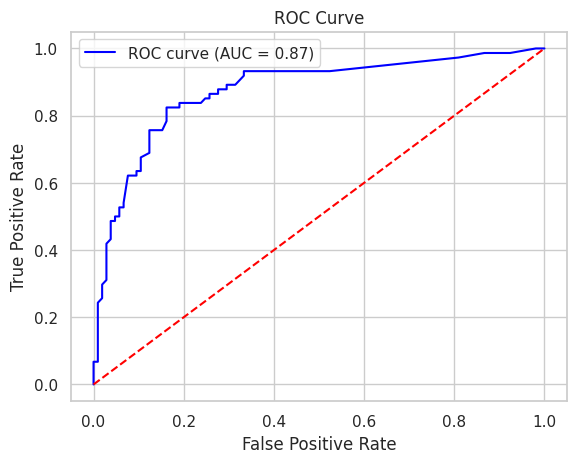

In [54]:
fpr,tpr,threshoud=roc_curve(y_val,y_pred_proba)
roc_auc=auc(fpr,tpr)
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [55]:
final_prediction=best_model.predict(X_test_submission)


In [56]:
submission=pd.DataFrame({'PassangerId':submission_ids,'Survived':final_prediction})

In [57]:
submission.to_csv('submission.csv',index=False)

In [58]:
print("\n Submision file'submission.csv' created successfully!")


 Submision file'submission.csv' created successfully!
